# Solutions to the JSON wrangling exercise

Import packages

In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

## JSON exercise questions

Using data in file 'data/world_bank_projects.json' and the techniques demonstrated above,
1. Find the 10 countries with most projects
2. Find the top 10 major project themes (using column 'mjtheme_namecode')
3. In 2. above you will notice that some entries have only the code and the name is missing. Create a dataframe with the missing names filled in.

***
### Question 1 : Find the 10 countries with most projects
First, we need to load the data and take a quick look at it.

In [2]:
#Load into a dataframe
df = pd.read_json('data/world_bank_projects.json')

#Use info() and head() to get at columns and rows info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 50 columns):
_id                         500 non-null object
approvalfy                  500 non-null int64
board_approval_month        500 non-null object
boardapprovaldate           500 non-null object
borrower                    485 non-null object
closingdate                 370 non-null object
country_namecode            500 non-null object
countrycode                 500 non-null object
countryname                 500 non-null object
countryshortname            500 non-null object
docty                       446 non-null object
envassesmentcategorycode    430 non-null object
grantamt                    500 non-null int64
ibrdcommamt                 500 non-null int64
id                          500 non-null object
idacommamt                  500 non-null int64
impagency                   472 non-null object
lendinginstr                495 non-null object
lendinginstrtype            495 non

We know this is World Bank data so we can explore it a little more. Since there is a date column, we can convert it to the datetime format. 

In [3]:
df['boardapprovaldate'] = pd.to_datetime(df['boardapprovaldate'])

This dataset is about lending projects from the World Bank to individual countries, so I'd like to know a litte more about the project financials. I use the *totalcommamt* along with the date to find the number of projects funded over time as well as the average project cost (amount) over time.

In [4]:
#Create new df just for this
df_date = df[['boardapprovaldate','totalcommamt']]
df_date.set_index('boardapprovaldate', inplace=True)
df_date.index.name = 'Month'

I want to look at this time series data per month so that it is not too granular. We can do this easily by resampling df_date and plotting. First I want to know the project counts, so we just aggregate a count() at the end of the resample. 

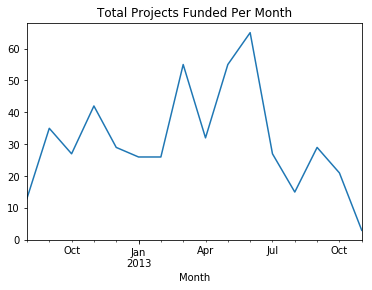

In [5]:
df_date.resample('M').count().plot(title='Total Projects Funded Per Month',legend=False)
plt.show()

We can see this dataset spans over a year, going from August 2012 to November 2013. To find the average project cost, we do the same thing as before except we aggregate using mean(). 

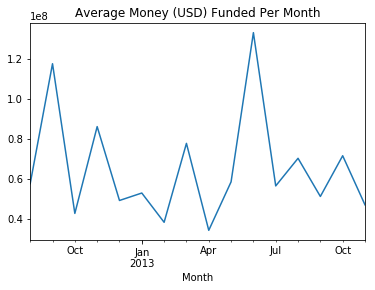

In [6]:
df_date.resample('M').mean().plot(title='Average Money (USD) Funded Per Month',legend=False)
plt.show()

This is pretty surprising to me. I cross-referenced the currency amounts and they are indeed in USD. So the World Bank averages over 50M USD monthly in project costs (although I assume this is an awarded amount and paid out over many years). Let's take a closer look at these project amounts. First we can just make a histogram. 

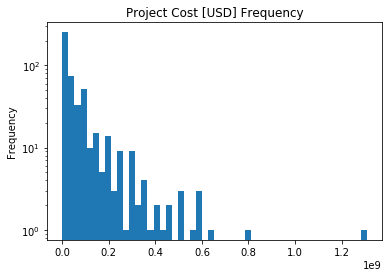

In [7]:
df['totalcommamt'].plot(kind='hist', bins=50, log=True, title='Project Cost [USD] Frequency')
plt.show()

As one might expect, the distribution is peaked at small values with a tail. But the tail extends all the way to 1.3B USD! We should check this out in a little more detail. Note in order to view the entire contents of this selected row, a few options have to be changed in pandas. 

In [8]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns' , 50)
(df[df['totalcommamt'] > 1.2e9]) 

,_id,approvalfy,board_approval_month,boardapprovaldate,borrower,closingdate,country_namecode,countrycode,countryname,countryshortname,docty,envassesmentcategorycode,grantamt,ibrdcommamt,id,idacommamt,impagency,lendinginstr,lendinginstrtype,lendprojectcost,majorsector_percent,mjsector_namecode,mjtheme,mjtheme_namecode,mjthemecode,prodline,prodlinetext,productlinetype,project_abstract,project_name,projectdocs,projectfinancialtype,projectstatusdisplay,regionname,sector,sector1,sector2,sector3,sector4,sector_namecode,sectorcode,source,status,supplementprojectflg,theme1,theme_namecode,themecode,totalamt,totalcommamt,url
129,{u'$oid': u'52b213b38594d8a2be17c801'},2013,June,2013-06-18,REPUBLIC OF POLAND,2014-06-30T00:00:00Z,Republic of Poland!$!PL,PL,Republic of Poland,Poland,"Implementation Status and Results Report,Loan Agreement,Program Document,Project Information Document",NaN,0,1307800000,P130459,0,MINISTRY OF FINANCE,Development Policy Lending,AD,1307800000,"[{u'Percent': 29, u'Name': u'Public Administration, Law, and Justice'}, {u'Percent': 29, u'Name': u'Public Administration, Law, and Justice'}, {u'Percent': 14, u'Name': u'Public Administration, Law, and Justice'}, {u'Percent': 14, u'Name': u'Finance'}, {u'Percent': 14, u'Name': u'Health and other social services'}]","[{u'code': u'BX', u'name': u'Public Administration, Law, and Justice'}, {u'code': u'BX', u'name': u'Public Administration, Law, and Justice'}, {u'code': u'BX', u'name': u'Public Administration, Law, and Justice'}, {u'code': u'FX', u'name': u'Finance'}, {u'code': u'JX', u'name': u'Health and other social services'}]","[Economic management, Public sector governance, Rule of law, Social protection and risk management, Social protection and risk management]","[{u'code': u'1', u'name': u'Economic management'}, {u'code': u'2', u'name': u'Public sector governance'}, {u'code': u'3', u'name': u'Rule of law'}, {u'code': u'6', u'name': u'Social protection and risk management'}, {u'code': u'6', u'name': u'Social protection and risk management'}]","1,2,3,6,6",PE,IBRD/IDA,L,"{u'cdata': u'The Second Public Finance Development Policy Loan Program is structured around three pillars with the following development objectives: 1) consolidating public finances to ensure a steady decline of the fiscal deficit to stabilize and over the medium term reduce public debt; 2) strengthening fiscal institutions to ingrain a prudent fiscal stance (including at the subnational level) over the medium term; and 3) advancing long-term fiscal reforms to secure the sustainability of social spending in view of Poland's demographic challenge program, in a programmatic series of two development policy loans, supports the government of Poland in strengthening its public finances. Sound macroeconomic policies coupled with limited external imbalances have helped Poland maintain economic growth despite the slowdown and economic uncertainty in Europe since 2008. Notwithstanding these positive developments over the past few years, Poland is not immune to the protracted recession in the Euro area. Poland's economy has performed well during and after the 2008 global financial crisis. Strong macroeconomic fundamentals, including limited macroeconomic imbalances at the onset of the crisis, large and diversified domestic economy, close trade and supply chain linkages to Germany and adequate policy mix prior to and during the crisis, helped the economy withstand external shocks. The growth in government spending was contained by: a) a temporary fiscal rule limiting increases in all newly enacted and existing discretionary expenditure items to one percentage point over the rate of inflation (CPI); and b) a nominal freeze of the budgetary sphere wage bill, and c) phasing out of early retirement schemes.'}",Development Policy Loan 2,"[{u'DocDate': u'03-SEP-2013', u'EntityID': u'090224b081e74696_1_0', u'DocURL': u'http://www-wds.worldbank.org/servlet/WDSServlet?pcont=details&eid=090224b081e74696_1_0', u'DocType': u'

This makes a little more sense. This project seems to be a large investment into Poland, helping to clear debts, strengthen financial institutions and develop long-term reforms and social stability. Let's take a look at some statistics for the project amounts as well.

In [9]:
#Return the options to their defaults!
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_columns' , 20)
df['totalcommamt'].describe()

count    5.000000e+02
mean     7.271386e+07
std      1.234705e+08
min      3.000000e+04
25%      5.000000e+06
50%      2.500000e+07
75%      9.045000e+07
max      1.307800e+09
Name: totalcommamt, dtype: float64

The average project amount is about 73M USD, but the standard is relativey large in comparison to the average at 120M USD. Without knowing anything about this dataset beforehand, this seems like large amounts. I would have expected numbers an order of magnitude lower, but it looks like my initial intuition on this is off. Switching gears back to the actual question, we can look at what types of countries are present in this dataset.

In [10]:
ncountries = len(set(df['countrycode']))
nprojects = len(set(df['project_name']))
print('There are %i projects in %i countries.' % (nprojects, ncountries))

There are 500 projects in 118 countries.


So there are 118 countries represented in this dataset. Let's use groupby to group all the countries together and count how many times they appear in the dataset. After sorting this result, we can get the top 10 countries (which is the answer to Question 1).

In [11]:
df_count = df.groupby('countryname')['project_name'].nunique()
df_count.sort_values(ascending=False)[:10]

countryname
People's Republic of China         19
Republic of Indonesia              19
Socialist Republic of Vietnam      17
Republic of India                  16
Republic of Yemen                  13
Nepal                              12
People's Republic of Bangladesh    12
Kingdom of Morocco                 12
Africa                             11
Republic of Mozambique             11
Name: project_name, dtype: int64

Everything looks good except we see at the bottom, 'Africa' listed as a country. Is this a mislabelling somehow? We should investigate this further. Let's select those 11 projects.

In [12]:
df.loc[df.countryname == 'Africa']

,_id,approvalfy,board_approval_month,boardapprovaldate,borrower,closingdate,country_namecode,countrycode,countryname,countryshortname,...,sectorcode,source,status,supplementprojectflg,theme1,theme_namecode,themecode,totalamt,totalcommamt,url
45,{u'$oid': u'52b213b38594d8a2be17c7ad'},2014,September,2013-09-12,ECOWAS,NaN,Africa!$!3A,3A,Africa,Africa,...,JA,IBRD,Active,N,"{u'Percent': 100, u'Name': u'Health system per...","[{u'code': u'67', u'name': u'Health system per...",67,0,10000000,http://www.worldbank.org/projects/P125018/west...
46,{u'$oid': u'52b213b38594d8a2be17c7ae'},2014,September,2013-09-10,UGANDA-COMOROS,2018-06-30T00:00:00Z,Africa!$!3A,3A,Africa,Africa,...,"BM,CA,CT",IBRD,Active,N,"{u'Percent': 20, u'Name': u'Administrative and...","[{u'code': u'25', u'name': u'Administrative an...","39,40,78,25",22000000,22000000,http://www.worldbank.org/projects/P118213/rcip...
51,{u'$oid': u'52b213b38594d8a2be17c7b3'},2014,September,2013-09-04,"OSS, IUCN, CILSS",NaN,Africa!$!3A,3A,Africa,Africa,...,"AI,AB,AZ,WZ",IBRD,Active,N,"{u'Percent': 20, u'Name': u'Biodiversity'}","[{u'code': u'80', u'name': u'Biodiversity'}, {...","85,82,81,83,80",0,4630000,http://www.worldbank.org/projects/P130888/buil...
58,{u'$oid': u'52b213b38594d8a2be17c7ba'},2014,August,2013-08-28,BANK EXECUTED,NaN,Africa!$!3A,3A,Africa,Africa,...,"AT,AZ",IBRD,Active,N,"{u'Percent': 50, u'Name': u'Biodiversity'}","[{u'code': u'80', u'name': u'Biodiversity'}, {...","82,80",0,2000000,http://www.worldbank.org/projects/P144902?lang=en
65,{u'$oid': u'52b213b38594d8a2be17c7c1'},2014,August,2013-08-06,"BURUNDI,RWANDA,TANZANIA",2020-12-31T00:00:00Z,Africa!$!3A,3A,Africa,Africa,...,LH,IBRD,Active,N,"{u'Percent': 15, u'Name': u'Infrastructure ser...","[{u'code': u'39', u'name': u'Infrastructure se...","47,79,62,39",339900000,339900000,http://www.worldbank.org/projects/P075941/nels...
99,{u'$oid': u'52b213b38594d8a2be17c7e3'},2013,June,2013-06-28,GOVERNMENT OF MALI,NaN,Africa!$!3A,3A,Africa,Africa,...,"YA,BL,AB",IBRD,Active,Y,"{u'Percent': 25, u'Name': u'Regional integrati...","[{u'code': u'47', u'name': u'Regional integrat...","78,27,48,47",60000000,60000000,http://www.worldbank.org/projects/P145160/addi...
167,{u'$oid': u'52b213b38594d8a2be17c827'},2013,May,2013-05-30,MINISTRIES OF TELECOM AND ICT,2018-11-30T00:00:00Z,Africa!$!3A,3A,Africa,Africa,...,"BZ,BM,CZ,CT",IBRD,Active,N,"{u'Percent': 25, u'Name': u'Regional integrati...","[{u'code': u'47', u'name': u'Regional integrat...","48,40,39,47",60000000,60000000,http://www.worldbank.org/projects/P123093/west...
184,{u'$oid': u'52b213b38594d8a2be17c838'},2013,May,2013-05-21,TANZANIA,2018-12-31T00:00:00Z,Africa!$!3A,3A,Africa,Africa,...,"BQ,BV,TI",IBRD,Active,N,"{u'Percent': 23, u'Name': u'Regional integrati...","[{u'code': u'47', u'name': u'Regional integrat...","88,74,49,47",213000000,213000000,http://www.worldbank.org/projects/P120370/sout...
287,{u'$oid': u'52b213b38594d8a2be17c89f'},2013,March,2013-03-14,"MALAWI, MOZAMBIQUE, ZAMBIA",2020-01-31T00:00:00Z,Africa!$!3A,3A,Africa,Africa,...,"AZ,AI,AH,BL,AB",IBRD,Active,N,"{u'Percent': 80, u'Name': u'Rural services and...","[{u'code': u'78', u'name': u'Rural services an...","47,48,78",90000000,90000000,http://www.worldbank.org/projects/P094183/agri...
353,{u'$oid': u'52b213b38594d8a2be17c8e1'},2013,January,2013-01-01,NILE BASIN INITIATIVE,2015-12-31T00:00:00Z,Africa!$!3A,3A,Africa,Africa,...,"BW,WZ",IBRD,Active,N,"{u'Percent': 74, u'Name': u'Water resource man...","[{u'code': u'85', u'name': u'Water resource ma...","82,57,85",0,15300000,http://www.worldbank.org/projects/P130694/nile...


Interesting. It looks like most of these projects are not given to a single country but to a multi-country inititative. Since these are all based in Africa, we can see why these projects are given that designation. However, there are a few that seem to be miscategorized: rows 99, 184, and 449 should probably belong to their own countries. I won't reclassify them here since there might be a good reason for these projects to be classed as they are. I would probably consult with someone with some knowledge on the subject. But it is good to dig a little.

***
### Question 2: Find the top 10 major project themes (using column 'mjtheme_namecode')
We know we need to dig into the list that is inside the *mjtheme_namecode* column. So we can use the json_normalize that was demonstrated in this exercise. Let's do that.

In [13]:
data = json.load((open('data/world_bank_projects.json')))
df2 = json_normalize(data, 'mjtheme_namecode')
df2.head()

,code,name
0,8,Human development
1,11,
2,1,Economic management
3,6,Social protection and risk management
4,5,Trade and integration


So we have a dataframe with the theme codes. To find the top 10 code themes, we again can use grouby to count the number of occurences for each code. After sorting, we can display the top 10.

In [14]:
df2_count = df2.groupby('code')['code'].count().sort_values(ascending=False)
df2_count[:10]

code
11    250
10    216
8     210
2     199
6     168
4     146
7     130
5      77
9      50
1      38
Name: code, dtype: int64

***
### Question 3: In 2. above you will notice that some entries have only the code and the name is missing. Create a dataframe with the missing names filled in.
As we already saw there were certain codes that did not have a name associated with the row. We will first make a new dataframe.

In [15]:
df3 = df2.copy()

In this type of problem, I like using groupby to make a sort of dictionary with code and codename pairs. If we remove all rows that have their name missing (i.e. the rows to fill) and group the remaining by code, we will have multiple copies of the same information. That is a group with a full mapping of the code to the codename. We can then simply pick one (or the last one) of these groups.

In [16]:
df3_temp = df3.loc[df3.name != ""].groupby('code')[['code','name']].last()
df3_temp

,code,name
code,,
1,1,Economic management
10,10,Rural development
11,11,Environment and natural resources management
2,2,Public sector governance
3,3,Rule of law
4,4,Financial and private sector development
5,5,Trade and integration
6,6,Social protection and risk management
7,7,Social dev/gender/inclusion


Next, with this dataframe in hand we can just join df3 with our map on code. Then we will have two codename columns, the original and the temp. This temp will be complete unlike the original one. Swapping these columns then gives us
the desired solution.

In [17]:
df3 = pd.merge(df3,df3_temp,how='left',left_on='code',right_on='code', suffixes=['','_temp'])
df3['name'] = df3['name_temp']
del df3['name_temp']
df3

,code,name
0,8,Human development
1,11,Environment and natural resources management
2,1,Economic management
3,6,Social protection and risk management
4,5,Trade and integration
5,2,Public sector governance
6,11,Environment and natural resources management
7,6,Social protection and risk management
8,7,Social dev/gender/inclusion
9,7,Social dev/gender/inclusion


Fin.